Regression on Diamonds data to predict diamond prices

Aim:
Find the best hyperparameters when applying alternative ensemble methods for regression problems 

START IPYTHON NOTEBOOK IN TERMINAL WITH : ipython notebook --script

CONTENT:

I. INITIALIZATION

I.1) Load libraries and functions

I.2) Change print settings

I.3) Set working directory

I.4) Data load

I.5) Set target variable

II. DATA INQUIRY

II.1) What is in the target variable?

II.2) Number of categorical variables, number of categories (min, max, mean)

II.3) Check distribution numeric variables, categories, and number of NA's and zero's

II.4) Check numerical variables for minima, maxima, mean

III. DATA PREPARATION

III.1) Fill NA's

III.2) One hot encoding categorical variables

III.3) Scaling by minimum-maximum

III.4) Split into input and output variables

III.5) Feature selection and reduction

III.6) Split into cross validation set and validation set

IV. MODELLING

IV.1) Model training preparation: set hyper parameters, initialize classifiers, prepare utilities

IV.2) Modelling with cross validation and hyper parameter tuning, prediction on "unseen" (validation) data, cross validation and validation set root mean squared error


I. INITIALIZATION

1) Load libraries and functions

In [417]:
from scipy.io.arff import loadarff 
import numpy as np
import arff
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sbn
import pandas as pd
import random as rd
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn import svm,ensemble
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.metrics import explained_variance_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, auc, roc_auc_score, roc_curve
from sklearn import pipeline as pl
from sklearn import metrics
from math import sqrt
import datetime, warnings, io, os, sys, types, nbimporter
import utilities as u
from importlib import reload
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

start_time=datetime.datetime.now()
print("starttime:",start_time)
gridsearch = 1
input_file = "diamonds.csv"
#reload(u)

starttime: 2020-08-27 12:23:06.097307


2) Change print settings
   (to see all output and avoid undesired warnings)

In [396]:
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)

3) Set working directory

In [397]:
path = os.path.join(os.getcwd())
os.chdir(path)
print("New or current working directory:",os.getcwd())

New or current working directory: /Users/uwekirsten/Local_Documents/Diamonds


4) Data load

In [398]:
df = df1 = pd.DataFrame(pd.read_csv(input_file, header = 0)).iloc[:,1:]

5) Set target variable

In [399]:
target = "price"
target_index = list(df.columns).index(target)
print(df[target], "\n", type(df[target]), "\n", "is int" if df[target].dtypes == int else "is not int" )

0         326
1         326
2         327
3         334
4         335
         ... 
53935    2757
53936    2757
53937    2757
53938    2757
53939    2757
Name: price, Length: 53940, dtype: int64 
 <class 'pandas.core.series.Series'> 
 is int


II. DATA INQUIRY

1) What is in the target variable ?

In [400]:
u.target_variable(df=df,target=target)

Numeric target variable with 
length 53940 , 
max  18823 , 
min 326 , 
and mean 3932.799721913237


2) Number of categorical variables, number of categories (min, max, average)

In [401]:
u.number_of_categories(df=df)

There are  3  categorical variables 
with  5.0  to  8.0  categories 
and an average number of  6.666666666666667  categories


result: 3 to 4 categories in each categorical variable, apply onehotencoding

3) Check distribution numeric variables, categories, and number of NA's and zero's

In [402]:
u.data_overview(df=df)

Data Types count:           a
b         
int64    1
float64  6
object   3  
from which:   
NA's:  0  
zero's:  35  
one's:  1558


4) Check numerical variables for minima, maxima, mean

In [403]:
u.numerics_overview(df=df)

number of numerics:  7  
maxima max:  18823.0  
maxima min:  5.01  
minima max:  326.0 
minima min:  0.0  
mean mean:  581.1155239154615


III. DATA PREPARATION

In [404]:
colnames=df.columns
d= "x_broad","y_high","z_deep"
colnames = np.append(colnames[:-3], d)
print(colnames)
df.columns = colnames

['carat' 'cut' 'color' 'clarity' 'depth' 'table' 'price' 'x_broad'
 'y_high' 'z_deep']


1) Fill NA's (numericals with mean and categoricals with a new "missing" category)

In [405]:
df = u.replace_na_of_categoricals_with_missing_category(df)
print("Number of NA's left: ", df.isnull().sum().sum()) # check if NA's are left
u.data_overview(df=df)
u.number_of_categories(df=df)
df.shape

Number of NA's left:  0
Data Types count:           a
b         
int64    1
float64  6
object   3  
from which:   
NA's:  0  
zero's:  35  
one's:  1558
There are  3  categorical variables 
with  5.0  to  8.0  categories 
and an average number of  6.666666666666667  categories


(53940, 10)

In [406]:
df = u.replace_na_of_numericals_with_mean(df=df)
print("Number of NA's left: ", df.isnull().sum().sum()) # check if NA's are left
u.data_overview(df=df)
df.describe()
df.shape

Number of NA's left:  0
Data Types count:           a
b         
int64    1
float64  6
object   3  
from which:   
NA's:  0  
zero's:  35  
one's:  1558


(53940, 10)

2) Onehotencoding of categorical variables

In [407]:
df = u.onehotencoding(X=df)

3) Scaling input variables

In [408]:
df = u.minmax_scaling_inputs(X=df) 
print("shape after min max scaling: ", df.shape)

shape after min max scaling:  (53940, 27)


4) Split into inputs and target

In [409]:
X, y = u.split_input_output(df=df,target=target)
X.shape

(53940, 26)

5) Feature selection and reduction

In [410]:
X=u.variance_threshold_selector(X=X, y=y, threshold=0.0)
print("shape after feature selection: ", X.shape, "\nremaining varibles:\n", X.columns)

shape after feature selection:  (53940, 26) 
remaining varibles:
 Index(['cut_Ideal', 'cut_Premium', 'cut_Good', 'cut_Very Good', 'cut_Fair',
       'color_E', 'color_I', 'color_J', 'color_H', 'color_F', 'color_G',
       'color_D', 'clarity_SI2', 'clarity_SI1', 'clarity_VS1', 'clarity_VS2',
       'clarity_VVS2', 'clarity_VVS1', 'clarity_I1', 'clarity_IF', 'carat',
       'depth', 'table', 'x_broad', 'y_high', 'z_deep'],
      dtype='object')


6) Split into cross validation set (train_test) and validationset (valid)

In [411]:
X_CV, X_valid, y_CV, y_valid = u.split_CVset_validationset(X=X, y=y, test_size=23940 , random_state= 100)
y_CV, y_valid = np.ravel(y_CV), np.ravel(y_valid) 
type(X_CV), type(y_CV), type(X_valid), type(y_valid)

(pandas.core.frame.DataFrame,
 numpy.ndarray,
 pandas.core.frame.DataFrame,
 numpy.ndarray)

IV. MODEL TRAINING

1) Model training preparation: Set hyperparameters, initialize classifiers, prepare utilities

In [418]:
# parameters by classifier
rf_params={
            'n_estimators': [110],
            'criterion': ["mse"],
            'max_depth': [7],     
            'min_samples_split': [2],
            'min_samples_leaf': [2],
            'max_features': ["auto"],    #  [0.5,0.7,0.9,"auto","log2"],
            'max_leaf_nodes': [8],     
            'min_impurity_decrease': [0.0],
            'min_impurity_split': [None],
            'bootstrap': [True],
            'oob_score': [False],
            'random_state':[1],
            'ccp_alpha': [0.0],
            'max_samples': [None]
            } 

gb_params={ 
            'loss': ["ls"],
            'learning_rate': [0.1], 
            'n_estimators': [110],
            'subsample': [0.8],
            'criterion': ["mse"], #"friedman_mse" "mae"
            'min_samples_split': [2],
            'min_samples_leaf': [2],
            'min_weight_fraction_leaf': [0.0],
            'max_depth': [7],
            'min_impurity_decrease': [0.0],
            'min_impurity_split': [None],
            'random_state': [2],
            'max_features': ["auto"], # "log2"
            'max_leaf_nodes': [8],
            'validation_fraction': [0.2, 0.3], 
            'n_iter_no_change': [None],
            'tol': [0.0001],
            'ccp_alpha': [0.0]
            }

xgb_params= {
             'booster': ["gblinear"],         #  ["gbtree", "gblinear"]
             'lambda': [0.1],                
             'learning_rate': [0.1],     
             'max_depth': [7],        
             'max_leaves': [8],
             'n_estimators': [110],  
             'objective':["reg:squarederror"], #  ["multi:softprob" , "multi:softmax" , "reg:tweedie"] 
             'subsample':  [0.8]       
             }

# regressors ####################################################################
RF=ensemble.RandomForestRegressor()
GB=ensemble.GradientBoostingRegressor()
XGB=xgb.XGBRegressor()

# utilities #####################################################################
regressors = [(RF,rf_params,"RF"),(GB,gb_params,"GB"),(XGB,xgb_params,"XGB")] ### (RF,rf_params,"RF"),(GB,gb_params,"GB"),(XGB,xgb_params,"XGB")
gridsearch = 1                        # 
n_fold = {5}                           # {2,3,4} # cross validation variants
metric= "neg_root_mean_squared_error"   # 
features = X_CV.columns                  # for feature contribution
resultfile = "GS_regression_results.csv"  # result storage in file
# headers for results storage: 
headers=["9) cv best params","8) validationset R square","7) validationset MAE", "5) validationset RMSE", "4) cv best mean test score","3) cv best mean train score", "2) cv n-fold","1) classifier"]

2) Modelling with cross validation and hyperparameter tuning, prediction on "unseen" (validation) data, 
   cross validation and validationset accuracies, validationset confusion matrices and feature contributions

RF
RF -model  5 -fold cross validation
5 -fold cross validation RF training start time: 0:00:08.309100
Grid Search  RF  cross validation:  5 -fold
Grid Search best  RF model 5 -fold parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': 8, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 110, 'oob_score': False, 'random_state': 1}
Grid Search best  RF model 5 -fold cross validation mean test neg_root_mean_squared_error :  -0.0707189750399095
Grid Search best  RF model 5 -fold cross validation mean train neg_root_mean_squared_error :  -0.07012320532583191
Grid Search  RF 5 -fold  cross validation results: 
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       4.285091      0.481365         0.048339        0.003713   

  param_bootstrap param_ccp_alpha param_criterion param_max_depth  \
0            Tru

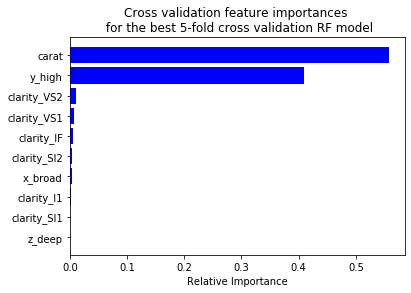

Validationset root mean squared error:  0.070
Validationset mean absolute error:  0.044
Validationset R square:  0.894


GB
GB -model  5 -fold cross validation
5 -fold cross validation GB training start time: 0:00:39.729718
Grid Search  GB  cross validation:  5 -fold
Grid Search best  GB model 5 -fold parameters:  {'ccp_alpha': 0.0, 'criterion': 'mse', 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': 8, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 110, 'n_iter_no_change': None, 'random_state': 2, 'subsample': 0.8, 'tol': 0.0001, 'validation_fraction': 0.2}
Grid Search best  GB model 5 -fold cross validation mean test neg_root_mean_squared_error :  -0.034690184983595045
Grid Search best  GB model 5 -fold cross validation mean train neg_root_mean_squared_error :  -0.032609615537346384
Grid Search  GB 5 -fold  cross validation results: 
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       5.770974      0.435665         0.025195       

Validationset root mean squared error:  0.033
Validationset mean absolute error:  0.018
Validationset R square:  0.976


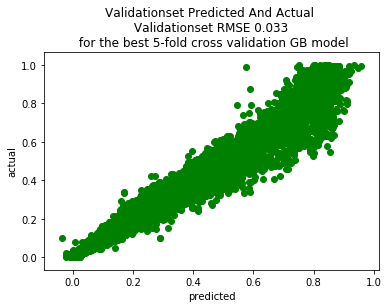

XGB
XGB -model  5 -fold cross validation
5 -fold cross validation XGB training start time: 0:01:48.835723
Grid Search  XGB  cross validation:  5 -fold
Grid Search best  XGB model 5 -fold parameters:  {'booster': 'gblinear', 'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'max_leaves': 8, 'n_estimators': 110, 'objective': 'reg:squarederror', 'subsample': 0.8}
Grid Search best  XGB model 5 -fold cross validation mean test neg_root_mean_squared_error :  -0.2102702779057374
Grid Search best  XGB model 5 -fold cross validation mean train neg_root_mean_squared_error :  -0.21026007440629657
Grid Search  XGB 5 -fold  cross validation results: 
   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_booster  \
0       3.638688      0.384304         0.008921        0.001466      gblinear   

  param_lambda param_learning_rate param_max_depth param_max_leaves  \
0          0.1                 0.1               7                8   

  param_n_estimators   param_objective param_

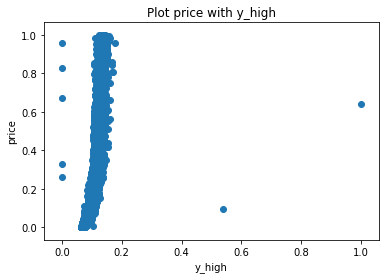

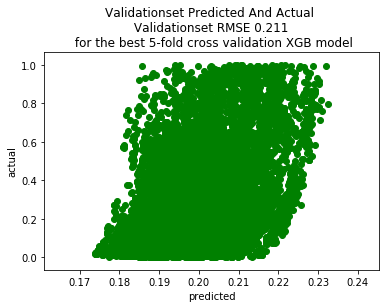

In [419]:
if gridsearch == 1:
    
    for c in regressors:
        print(c[2]) # print current classifier
        
        for n in n_fold:
            print(c[2],"-model ", n,"-fold cross validation") # print current cross validation
            
            # time check ########################################################################################
            print(n,"-fold cross validation",c[2],"training start time:", datetime.datetime.now() - start_time)
            
            # hyperparameter training in cross validation #######################################################
            GS = GridSearchCV(estimator=c[0], param_grid=c[1], scoring=metric, cv=n, return_train_score=True)
            GS.fit(X_CV,y_CV)
            
            # cross validation prints for result check ##########################################################
            print("Grid Search ",c[2]," cross validation: ",n,"-fold")
            print("Grid Search best ",c[2],"model",n,"-fold parameters: ", GS.best_params_)
            print("Grid Search best ",c[2],"model",n,"-fold cross validation mean test",metric,": ", GS.best_score_) 
            print("Grid Search best ",c[2],"model",n,"-fold cross validation mean train",metric,": ", pd.DataFrame(GS.cv_results_)["mean_train_score"].max()) 
            test_metric=format(round(GS.best_score_,4), '.3f')
            train_metric=format(pd.DataFrame(GS.cv_results_)["mean_train_score"].max(), '.3f')
            print("Grid Search ",c[2],n,"-fold"," cross validation results: ")
            print(pd.DataFrame(GS.cv_results_))
            
            # feature contribution in cross validation ##########################################################
            try: 
                importances=GS.best_estimator_.feature_importances_
                ind = np.argsort(importances)
                indices = ind[-10:] 
                plt.title("Cross validation feature importances \n for the best %s-fold cross validation %s model" %(n,c[2]))
                plt.barh(range(len(indices)), importances[indices], color='b', align='center')
                plt.yticks(range(len(indices)), [features[i] for i in indices])
                plt.xlabel('Relative Importance')
                plt.show()
            except:
                pass
            
            # RMSE , MAE, MSLE of best model on validation set ##################################################
            y_pred=GS.best_estimator_.predict(X_valid)
            val_mse = mean_squared_error(y_true=y_valid, y_pred=y_pred)
            val_rmse = format(val_mse**(0.5), '.3f')
            print("Validationset root mean squared error: ", val_rmse)
            val_mae = format(mean_absolute_error(y_true=y_valid, y_pred=y_pred), '.3f')
            print("Validationset mean absolute error: ", val_mae)
            val_R2 = format(r2_score(y_true=y_valid, y_pred=y_pred), '.3f')
            print("Validationset R square: ", val_R2)
            
            # plot model ########################################################################################
            try: 
                plt.scatter(x=X_CV.iloc[:,ind[-1]], y=y_CV)
                plt.title(str("Plot " + target + " with " + X_CV.columns[ind[-1]]))
                plt.xlabel(X_CV.columns[ind[-1]])
                plt.ylabel('price')
                plt.show()
            except:
                pass
            
            # plot validation set result ########################################################################
            plt.scatter(x=y_pred, y=y_valid,color='g')
            plt.title("Validationset Predicted And Actual \n Validationset RMSE %s \n for the best %s-fold cross validation %s model" %(val_rmse,n,c[2]))
            plt.xlabel('predicted')
            plt.ylabel('actual')
            plt.show()
            
            # results collection ################################################################################
            #####################################################################################################
            # load former results file as data frame and delete old file ########################
            # or - if not existent - initialize new results data frame ##########################
            try: 
                GS_results_df = pd.DataFrame(pd.read_csv(resultfile)) # fetches the existing result file
            except: 
                GS_results_df = pd.DataFrame(columns=headers) # creates new result file
            
            # append current results to existent results data frame
            GS_results_df = GS_results_df.append(pd.DataFrame([[str(GS.best_params_),val_msle,val_mae,val_rmse,test_metric,train_metric,n,c[2]]],columns=headers))
            
            try:
                GS_results_df = GS_results_df.drop("Unnamed: 0",axis=1) # delete undesired column "Unnamed: 0" 
            except:
                print("no 'Unnamed: 0' column to remove from result matrix") # if the column does not exist yet
            
            try:
                result_path = path + "/" + resultfile
                os.remove(path= result_path, dir_fd=None) # remove result file from directory if it exists 
            except:
                print("no file to remove")
            
             ###########################################################
            GS_results_df.to_csv(resultfile,sep=",") # store results in folder

In [ ]:
metrics.SCORERS.keys()

In [ ]:
print("runtime: ", datetime.datetime.now() - start_time)